In [ ]:
# A) Mount Drive and set the path to your CSV in Drive
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/On-street_Car_Parking_Sensor_Data_-_2019.csv" # <-- change me
OUT_DIR  = "/content/drive/MyDrive/smart_parking_out"  # outputs saved here


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

In [ ]:
cols = pd.read_csv(CSV_PATH, nrows=0).columns.tolist()
print("Columns:", len(cols))
print(cols)

Columns: 20
['DeviceId', 'ArrivalTime', 'DepartureTime', 'DurationMinutes', 'StreetMarker', 'SignPlateID', 'Sign', 'AreaName', 'StreetId', 'StreetName', 'BetweenStreet1ID', 'BetweenStreet1', 'BetweenStreet2ID', 'BetweenStreet2', 'SideOfStreet', 'SideOfStreetCode', 'SideName', 'BayId', 'InViolation', 'VehiclePresent']


In [ ]:
peek = pd.read_csv(CSV_PATH, nrows=5, low_memory=False)
print("\n--- HEAD (5 rows) ---")
display(peek)


--- HEAD (5 rows) ---


,DeviceId,ArrivalTime,DepartureTime,DurationMinutes,StreetMarker,SignPlateID,Sign,AreaName,StreetId,StreetName,BetweenStreet1ID,BetweenStreet1,BetweenStreet2ID,BetweenStreet2,SideOfStreet,SideOfStreetCode,SideName,BayId,InViolation,VehiclePresent
0,23915,11/03/2019 03:00:56 AM,11/03/2019 03:07:26 AM,7,2374N,NaN,NaN,Windsor,123,BOURKE STREET,1221,RUSSELL STREET,647,EXHIBITION STREET,3,N,North,1753,False,False
1,23914,04/16/2019 02:14:47 PM,04/16/2019 02:15:23 PM,1,1896N,287.0,1P MTR M-SAT 7:30-18:30,Twin Towers,528,COLLINS STREET,647,EXHIBITION STREET,1288,SPRING STREET,3,N,North,1532,False,False
2,23913,09/29/2019 01:08:22 AM,09/29/2019 01:31:41 AM,23,1581S,NaN,NaN,Banks,670,FLINDERS STREET,1171,QUEEN STREET,627,ELIZABETH STREET,4,S,South,1399,False,False
3,23915,06/05/2019 06:59:17 PM,06/05/2019 06:59:24 PM,0,2374N,508.0,2P MTR M-SAT 18.30 - 20.30,Windsor,123,BOURKE STREET,1221,RUSSELL STREET,647,EXHIBITION STREET,3,N,North,1753,False,False
4,23915,04/01/2019 07:03:41 AM,04/01/2019 07:14:12 AM,11,2374N,NaN,NaN,Windsor,123,BOURKE STREET,1221,RUSSELL STREET,647,EXHIBITION STREET,3,N,North,1753,False,True


In [ ]:
sample = pd.read_csv(CSV_PATH, nrows=200_000, low_memory=False)
print("\n--- DTYPE inference from first 200k rows ---")
print(sample.dtypes)


--- DTYPE inference from first 200k rows ---
DeviceId              int64
ArrivalTime          object
DepartureTime        object
DurationMinutes      object
StreetMarker         object
SignPlateID         float64
Sign                 object
AreaName             object
StreetId              int64
StreetName           object
BetweenStreet1ID      int64
BetweenStreet1       object
BetweenStreet2ID      int64
BetweenStreet2       object
SideOfStreet          int64
SideOfStreetCode     object
SideName             object
BayId                 int64
InViolation            bool
VehiclePresent         bool
dtype: object


In [ ]:
total_rows = 0
non_null_counts = defaultdict(int)

In [ ]:
vehiclepresent_counter = Counter()
inviolation_counter = Counter()
streetmarker_counter = Counter()

In [ ]:
arrival_min = pd.NaT
arrival_max = pd.NaT
depart_min = pd.NaT
depart_max = pd.NaT

In [ ]:
# ====== CONFIG ======
CSV_PATH = "/content/drive/MyDrive/On-street_Car_Parking_Sensor_Data_-_2019.csv"
OUT_DIR  = "/content/drive/MyDrive/smart_parking_out"
PER_CLASS = 7_500
CHUNK_ROWS = 250_000

import os, pandas as pd, numpy as np
os.makedirs(OUT_DIR, exist_ok=True)

# Use the dtype hints you discovered (for faster/safer reading)
# Note: Arrival/Departure/Duration read as strings -> we’ll parse/convert after
dtype_map = {
    "DeviceId": "Int64",
    "ArrivalTime": "string",
    "DepartureTime": "string",
    "DurationMinutes": "string",
    "StreetMarker": "string",
    "SignPlateID": "Float64",   # will convert to Int64 later if you want
    "Sign": "string",
    "AreaName": "string",
    "StreetId": "Int64",
    "StreetName": "string",
    "BetweenStreet1ID": "Int64",
    "BetweenStreet1": "string",
    "BetweenStreet2ID": "Int64",
    "BetweenStreet2": "string",
    "SideOfStreet": "Int64",
    "SideOfStreetCode": "string",
    "SideName": "string",
    "BayId": "Int64",
    "InViolation": "boolean",
    "VehiclePresent": "boolean",
}

usecols = list(dtype_map.keys())

def normalize_chunk(df: pd.DataFrame) -> pd.DataFrame:
    # Parse timestamps
    df["ArrivalTime"]   = pd.to_datetime(df["ArrivalTime"],   errors="coerce")
    df["DepartureTime"] = pd.to_datetime(df["DepartureTime"], errors="coerce")

    # Duration to seconds
    dm = pd.to_numeric(df["DurationMinutes"], errors="coerce")
    df["DurationSeconds"] = dm * 60.0

    # Status from boolean VehiclePresent (fallback: dep>arr if NA)
    vp = df["VehiclePresent"]
    # Ensure boolean/NA is handled; if dtype isn't boolean already:
    if vp.dtype != "boolean":
        vp = vp.astype("string").str.lower().map({"true": True, "1": True, "yes": True,
                                                  "false": False, "0": False, "no": False})
    fallback = (df["DepartureTime"] > df["ArrivalTime"])
    occ = vp.fillna(fallback)
    df["Status"] = np.where(occ, "Present", "NotPresent")

    # Clean rows
    df = df.dropna(subset=["BayId","ArrivalTime","DepartureTime","DurationSeconds"])
    df = df[df["DurationSeconds"] >= 0]

    # Optional: SignPlateID to nullable Int64 if you prefer integers
    if "SignPlateID" in df.columns:
        df["SignPlateID"] = pd.to_numeric(df["SignPlateID"], errors="coerce").round().astype("Int64")

    # Features
    df["Hour"]        = df["ArrivalTime"].dt.hour
    df["DayOfWeek"]   = df["ArrivalTime"].dt.dayofweek + 1  # 1..7
    df["Month"]       = df["ArrivalTime"].dt.month
    df["DayOfMonth"]  = df["ArrivalTime"].dt.day
    df["IsWeekend"]   = df["DayOfWeek"].isin([1,7])
    df["DwellMinutes"]= df["DurationSeconds"] / 60.0
    df["PartOfDay"]   = pd.cut(
        df["Hour"], bins=[-1,5,11,16,21,24],
        labels=["Night","Morning","Afternoon","Evening","Night"], right=True, ordered=False
    )

    # Dedup inside chunk (helps reduce exact duplicates early)
    df = df.drop_duplicates(subset=["BayId","ArrivalTime","DepartureTime"], keep="first")
    return df

# ------- Balanced reservoir sampling (memory-light) -------
rng = np.random.default_rng(42)
occ_res, vac_res = [], []
occ_seen = vac_seen = 0

def add_reservoir(res, seen, rows, k):
    # rows: DataFrame
    for _, r in rows.iterrows():
        seen += 1
        if len(res) < k:
            res.append(r)
        else:
            j = rng.integers(0, seen)
            if j < k:
                res[j] = r
    return seen

reader = pd.read_csv(
    CSV_PATH,
    usecols=usecols,
    dtype=dtype_map,
    chunksize=CHUNK_ROWS,
    low_memory=False
)

for i, chunk in enumerate(reader):
    chunk = normalize_chunk(chunk)
    occ = chunk[chunk["Status"]=="Present"]
    vac = chunk[chunk["Status"]=="NotPresent"]

    occ_seen = add_reservoir(occ_res, occ_seen, occ, PER_CLASS)
    vac_seen = add_reservoir(vac_res, vac_seen, vac, PER_CLASS)

    print(f"[chunk {i}] occ_res={len(occ_res)}/{PER_CLASS}  vac_res={len(vac_res)}/{PER_CLASS}")

    if len(occ_res) >= PER_CLASS and len(vac_res) >= PER_CLASS:
        break  # both buckets filled

# Build final balanced 15k (or min if class is smaller)
occ_df = pd.DataFrame(occ_res)
vac_df = pd.DataFrame(vac_res)
m = min(len(occ_df), len(vac_df), PER_CLASS)
occ_df = occ_df.sample(n=m, random_state=42) if len(occ_df) > m else occ_df
vac_df = vac_df.sample(n=m, random_state=42) if len(vac_df) > m else vac_df

out = pd.concat([occ_df, vac_df], ignore_index=True).sample(frac=1.0, random_state=42)
# Final cross-chunk dedup
out = out.drop_duplicates(subset=["BayId","ArrivalTime","DepartureTime"], keep="first")

# Final column order
keep_cols = [
    "BayId","DeviceId","StreetMarker","StreetName","Sign","Status",
    "ArrivalTime","DepartureTime","DurationSeconds",
    "Hour","DayOfWeek","IsWeekend","Month","DayOfMonth","PartOfDay","DwellMinutes",
    # extras you might want handy:
    "AreaName","StreetId","InViolation","SignPlateID","SideName","SideOfStreet","SideOfStreetCode"
]
keep_cols = [c for c in keep_cols if c in out.columns]
out = out[keep_cols]

# Save + head
csv_out = f"{OUT_DIR.rstrip('/')}/smart_parking_15k.csv"
pq_out  = f"{OUT_DIR.rstrip('/')}/smart_parking_15k.parquet"

out.to_csv(csv_out, index=False)
try:
    import pyarrow  # noqa
    out.to_parquet(pq_out, index=False)
    print(f"✅ Saved Parquet: {pq_out}")
except Exception as e:
    print("ℹ️ Parquet save skipped (install pyarrow to enable).")

print(f"✅ Saved CSV: {csv_out}")
print("Rows:", len(out), "| Present share:", (out['Status']=='Present').mean())

# HEAD print
print("\n--- HEAD (first 5 rows) ---")
display(out.head(5))

[chunk 0] occ_res=7500/7500  vac_res=7500/7500
✅ Saved Parquet: /content/drive/MyDrive/smart_parking_out/smart_parking_15k.parquet
✅ Saved CSV: /content/drive/MyDrive/smart_parking_out/smart_parking_15k.csv
Rows: 15000 | Present share: 0.5

--- HEAD (first 5 rows) ---


,BayId,DeviceId,StreetMarker,StreetName,Sign,Status,ArrivalTime,DepartureTime,DurationSeconds,Hour,...,DayOfMonth,PartOfDay,DwellMinutes,AreaName,StreetId,InViolation,SignPlateID,SideName,SideOfStreet,SideOfStreetCode
11499,5872,23933,C9190,FARADAY STREET,<NA>,NotPresent,2019-03-16 00:00:00,2019-03-16 07:30:00,27000.0,0,...,16,Night,450.0,University,655,False,<NA>,Centre,1,C
6475,6037,23967,13085S,COLLINS STREET,<NA>,Present,2019-01-10 18:30:00,2019-01-10 18:30:59,0.0,18,...,10,Evening,0.0,Docklands,528,False,<NA>,South,4,S
13167,1399,23913,1581S,FLINDERS STREET,2P MTR M-F 18:30-20:30,NotPresent,2019-11-06 18:30:00,2019-11-06 18:37:45,420.0,18,...,6,Evening,7.0,Banks,670,False,12,South,4,S
862,2552,23938,C3084,LONSDALE STREET,2P MTR M-SAT 7:30-20:30,Present,2019-03-27 12:37:50,2019-03-27 14:28:58,6660.0,12,...,27,Afternoon,111.0,Supreme,894,False,145,Centre,1,C
5970,6037,23967,13085S,COLLINS STREET,2P MTR M-F 7:30-18:30,Present,2019-04-11 10:10:55,2019-04-11 10:13:41,180.0,10,...,11,Morning,3.0,Docklands,528,False,205,South,4,S


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Example paths (adjust as needed):
RAW_CSV_PATH = "/content/drive/MyDrive/smart_parking_out/smart_parking_15k.csv"  # <-- put your file here
OUT_DIR = "/content/drive/MyDrive/parking/delta/bronze_events"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

os.makedirs(OUT_DIR, exist_ok=True)

def to_dt(s):
    # robust timestamp parser
    return pd.to_datetime(s, errors="coerce", infer_datetime_format=True)

# choose-first helper
def pick(colnames, options):
    for o in options:
        if o in colnames: return o
    return None


In [ ]:
assert os.path.exists(RAW_CSV_PATH), f"File not found: {RAW_CSV_PATH}"
df_raw = pd.read_csv(RAW_CSV_PATH)
df_raw.columns = [c.strip() for c in df_raw.columns]
print("Rows x Cols:", df_raw.shape)
df_raw.head(5)


Rows x Cols: (15000, 23)


,BayId,DeviceId,StreetMarker,StreetName,Sign,Status,ArrivalTime,DepartureTime,DurationSeconds,Hour,...,DayOfMonth,PartOfDay,DwellMinutes,AreaName,StreetId,InViolation,SignPlateID,SideName,SideOfStreet,SideOfStreetCode
0,5872,23933,C9190,FARADAY STREET,NaN,NotPresent,2019-03-16 00:00:00,2019-03-16 07:30:00,27000.0,0,...,16,Night,450.0,University,655,False,NaN,Centre,1,C
1,6037,23967,13085S,COLLINS STREET,NaN,Present,2019-01-10 18:30:00,2019-01-10 18:30:59,0.0,18,...,10,Evening,0.0,Docklands,528,False,NaN,South,4,S
2,1399,23913,1581S,FLINDERS STREET,2P MTR M-F 18:30-20:30,NotPresent,2019-11-06 18:30:00,2019-11-06 18:37:45,420.0,18,...,6,Evening,7.0,Banks,670,False,12.0,South,4,S
3,2552,23938,C3084,LONSDALE STREET,2P MTR M-SAT 7:30-20:30,Present,2019-03-27 12:37:50,2019-03-27 14:28:58,6660.0,12,...,27,Afternoon,111.0,Supreme,894,False,145.0,Centre,1,C
4,6037,23967,13085S,COLLINS STREET,2P MTR M-F 7:30-18:30,Present,2019-04-11 10:10:55,2019-04-11 10:13:41,180.0,10,...,11,Morning,3.0,Docklands,528,False,205.0,South,4,S


In [ ]:
df = df_raw.copy()

# Identify likely column names (works with common variants)
COLS = {
  "device":  pick(df.columns, ["DeviceId","device_id","bay_id"]),
  "street":  pick(df.columns, ["StreetMarker","street_marker","zone","street"]),
  "sign":    pick(df.columns, ["SignPlateID","sign_plate_id"]),
  "arrive":  pick(df.columns, ["ArrivalTime","arrival_time","Arrival","arrival","Timestamp","timestamp","_arrive_dt"]),
  "depart":  pick(df.columns, ["DepartureTime","departure_time","Departure","departure","_depart_dt"]),
  "status":  pick(df.columns, ["Status","status","_status","occupied","is_occupied","_status_bin"]),
  "duration":pick(df.columns, ["DurationMinutes","duration_minutes","Duration","duration","_duration_min"]),
}

# Parse timestamps
if COLS["arrive"] is not None: df[COLS["arrive"]] = to_dt(df[COLS["arrive"]])
if COLS["depart"] is not None: df[COLS["depart"]] = to_dt(df[COLS["depart"]])

# If only one timestamp is present, use it for both to enable minimal features
if COLS["arrive"] is None and COLS["depart"] is not None:
    df["_arrive_dt"] = df[COLS["depart"]]; COLS["arrive"] = "_arrive_dt"
if COLS["depart"] is None and COLS["arrive"] is not None:
    df["_depart_dt"] = df[COLS["arrive"]]; COLS["depart"] = "_depart_dt"

# Duration (minutes)
if COLS["duration"] is not None:
    df["_duration_min"] = pd.to_numeric(df[COLS["duration"]], errors="coerce")
else:
    df["_duration_min"] = np.nan
if df["_duration_min"].isna().all() and COLS["arrive"] and COLS["depart"]:
    df["_duration_min"] = (df[COLS["depart"]] - df[COLS["arrive"]]).dt.total_seconds() / 60.0

# Normalize status → occupied ∈ {0,1}
if COLS["status"] is not None:
    s = df[COLS["status"]].astype(str).str.strip().str.lower()
    df["_occupied"] = np.where(s.isin(["present","occupied","1","true"]), 1,
                        np.where(s.isin(["notpresent","vacant","0","false"]), 0, np.nan))
else:
    # Fallback: if duration>0 treat as occupied (for session-like records)
    df["_occupied"] = (df["_duration_min"].fillna(0) > 0).astype(int)

# Basic validity filter (don’t drop from original; create a cleaned view)
valid = pd.Series(True, index=df.index)
if COLS["arrive"]: valid &= df[COLS["arrive"]].notna()
if COLS["depart"]: valid &= df[COLS["depart"]].notna()
valid &= df["_duration_min"].notna()
valid &= (df["_duration_min"] >= 0) & (df["_duration_min"] <= 24*60)

df_clean = df.loc[valid].copy()

# Feature engineering
df_clean["_event_time"]  = df_clean[COLS["arrive"]]
df_clean["_hour"]        = df_clean["_event_time"].dt.hour
df_clean["_dow"]         = df_clean["_event_time"].dt.dayofweek   # 0=Mon..6=Sun
df_clean["_is_weekend"]  = df_clean["_dow"].isin([5,6]).astype(int)

# Simple outlier flag on duration
mu, sigma = df_clean["_duration_min"].mean(), df_clean["_duration_min"].std(ddof=0)
df_clean["_duration_outlier"] = ((df_clean["_duration_min"] - mu).abs() > 3*sigma).astype(int)

print("Rows after cleaning:", len(df_clean), " / original:", len(df))
df_clean.head(5)


Rows after cleaning: 15000  / original: 15000


/tmp/ipython-input-3370659575.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3370659575.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", infer_datetime_format=True)


,BayId,DeviceId,StreetMarker,StreetName,Sign,Status,ArrivalTime,DepartureTime,DurationSeconds,Hour,...,SideName,SideOfStreet,SideOfStreetCode,_duration_min,_occupied,_event_time,_hour,_dow,_is_weekend,_duration_outlier
0,5872,23933,C9190,FARADAY STREET,NaN,NotPresent,2019-03-16 00:00:00,2019-03-16 07:30:00,27000.0,0,...,Centre,1,C,450.000000,0.0,2019-03-16 00:00:00,0,5,1,1
1,6037,23967,13085S,COLLINS STREET,NaN,Present,2019-01-10 18:30:00,2019-01-10 18:30:59,0.0,18,...,South,4,S,0.983333,1.0,2019-01-10 18:30:00,18,3,0,0
2,1399,23913,1581S,FLINDERS STREET,2P MTR M-F 18:30-20:30,NotPresent,2019-11-06 18:30:00,2019-11-06 18:37:45,420.0,18,...,South,4,S,7.750000,0.0,2019-11-06 18:30:00,18,2,0,0
3,2552,23938,C3084,LONSDALE STREET,2P MTR M-SAT 7:30-20:30,Present,2019-03-27 12:37:50,2019-03-27 14:28:58,6660.0,12,...,Centre,1,C,111.133333,1.0,2019-03-27 12:37:50,12,2,0,0
4,6037,23967,13085S,COLLINS STREET,2P MTR M-F 7:30-18:30,Present,2019-04-11 10:10:55,2019-04-11 10:13:41,180.0,10,...,South,4,S,2.766667,1.0,2019-04-11 10:10:55,10,3,0,0


In [ ]:
# 1) Trim whitespace in key string cols
for c in [COLS["device"], COLS["street"], COLS["sign"], COLS["status"]]:
    if c and c in df_clean.columns:
        df_clean[c] = df_clean[c].astype(str).str.strip()

# 2) Canonicalize device/street IDs (upper-case, collapse internal spaces)
for c in [COLS["device"], COLS["street"]]:
    if c and c in df_clean.columns:
        df_clean[c] = (df_clean[c]
                       .str.upper()
                       .str.replace(r"\s+", " ", regex=True))

# 3) Drop exact duplicate event records
dedup_keys = [k for k in [COLS["device"], COLS["street"], COLS["sign"],
                          COLS["arrive"], COLS["depart"], COLS["status"]] if k]
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=dedup_keys or None)
print(f"Deduplicated: {before-len(df_clean)} rows removed.")


Deduplicated: 0 rows removed.


In [ ]:
# If timestamps are naive, assign a timezone then convert (adjust to your city tz)
local_tz = "America/New_York"  # change if needed

for tcol in [COLS["arrive"], COLS["depart"]]:
    if tcol and pd.api.types.is_datetime64_any_dtype(df_clean[tcol]):
        if df_clean[tcol].dt.tz is None:
            df_clean[tcol] = df_clean[tcol].dt.tz_localize(local_tz, nonexistent="shift_forward", ambiguous="NaT")
        df_clean[tcol] = df_clean[tcol].dt.tz_convert("UTC")

# Recompute features after tz normalization
df_clean["_event_time"] = df_clean[COLS["arrive"]]
df_clean["_hour"] = df_clean["_event_time"].dt.tz_convert(local_tz).dt.hour
df_clean["_dow"]  = df_clean["_event_time"].dt.tz_convert(local_tz).dt.dayofweek
df_clean["_is_weekend"] = df_clean["_dow"].isin([5,6]).astype(int)

# Filter obvious bad dates (future/past bounds)
upper = pd.Timestamp("now", tz="UTC") + pd.Timedelta(days=1)
lower = pd.Timestamp("2000-01-01", tz="UTC")
mask_date = df_clean["_event_time"].between(lower, upper)
print("Dropped for date bounds:", (~mask_date).sum())
df_clean = df_clean[mask_date].copy()


Dropped for date bounds: 1


In [ ]:
# Clip extreme durations to reduce model sensitivity (keeps distribution shape)
p_low, p_high = df_clean["_duration_min"].quantile([0.001, 0.999])
df_clean["_duration_min_w"] = df_clean["_duration_min"].clip(lower=p_low, upper=p_high)

# Optional robust z-score for flags (median & MAD)
med = df_clean["_duration_min"].median()
mad = (df_clean["_duration_min"] - med).abs().median()
df_clean["_duration_robust_z"] = 0.6745 * (df_clean["_duration_min"] - med) / (mad if mad else 1)


In [ ]:
def lump_rare(series, min_count=50, other_label="_OTHER"):
    vc = series.value_counts()
    keep = vc[vc >= min_count].index
    return series.where(series.isin(keep), other_label)

if COLS["street"]:
    df_clean["street_marker_lumped"] = lump_rare(df_clean[COLS["street"]].astype(str), min_count=50)
if COLS["device"]:
    df_clean["device_id_lumped"] = lump_rare(df_clean[COLS["device"]].astype(str), min_count=20)


In [ ]:
# Duration impute: median per street/device, else global median
global_med = df_clean["_duration_min"].median()
if COLS["street"]:
    med_by_street = df_clean.groupby(COLS["street"])["_duration_min"].transform("median")
    df_clean["_duration_min_imp"] = df_clean["_duration_min"].fillna(med_by_street).fillna(global_med)
else:
    df_clean["_duration_min_imp"] = df_clean["_duration_min"].fillna(global_med)

# Status (occupied) impute: default to 0 if truly unknown
df_clean["_occupied_imp"] = df_clean["_occupied"].fillna(0).astype(int)

# FINAL target column (pick one and stick with it)
df_clean["target_occupied"] = df_clean["_occupied_imp"]


In [ ]:
# Sort by device + time; rolling features use only PAST data
grp = COLS["device"] if COLS["device"] else COLS["street"]
if grp:
    df_clean = df_clean.sort_values([grp, "_event_time"]).reset_index(drop=True)

    def rolling_mean_past(x, col, minutes):
        # Convert timestamp to seconds since epoch to make a time-aware rolling window
        ts = x["_event_time"].view(np.int64) // 10**9  # seconds
        # We'll do a simple fixed-size rolling (e.g., last N=10) as a stand-in for time-based
        return x[col].rolling(window=10, min_periods=1).mean()

    # Rolling occupancy in the past N events (proxy for 60 min)
    df_clean["rolling_occ_N10"] = df_clean.groupby(grp)["target_occupied"].apply(lambda x: x.rolling(10, min_periods=1).mean()).reset_index(level=0, drop=True)

    # Rolling arrivals per hour proxy: count in last N
    df_clean["arrivals_N10"] = df_clean.groupby(grp)["target_occupied"].cumcount() - \
                               df_clean.groupby(grp)["target_occupied"].cumcount().shift(10).fillna(-1)

else:
    print("No device/zone column found; skipping rolling features.")


In [ ]:
# One-hot (safe for small cardinality); otherwise keep the lumped versions
cat_cols = []
if "street_marker_lumped" in df_clean.columns: cat_cols.append("street_marker_lumped")
if "device_id_lumped" in df_clean.columns:     cat_cols.append("device_id_lumped")

X_cat = pd.get_dummies(df_clean[cat_cols], prefix=cat_cols, dummy_na=False) if cat_cols else pd.DataFrame(index=df_clean.index)

# Numeric features
num_cols = ["_hour","_dow","_is_weekend","_duration_min_w","rolling_occ_N10","arrivals_N10"]
num_cols = [c for c in num_cols if c in df_clean.columns]
X_num = df_clean[num_cols].copy()

# Final design matrix
X = pd.concat([X_num, X_cat], axis=1)
y = df_clean["target_occupied"].astype(int)

print("X shape:", X.shape, "y:", y.shape)


X shape: (14999, 72) y: (14999,)


In [ ]:
# Time-aware split: first 70% earliest → train, next 15% → val, last 15% → test
q1, q2 = df_clean["_event_time"].quantile([0.70, 0.85])
train_idx = df_clean["_event_time"] <= q1
val_idx   = (df_clean["_event_time"] > q1) & (df_clean["_event_time"] <= q2)
test_idx  = df_clean["_event_time"] > q2

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Split sizes:", len(y_train), len(y_val), len(y_test))


Split sizes: 10499 2250 2250


In [ ]:
assert X.isna().sum().sum() == 0, "Unexpected NaNs in features"
assert set(y.unique()) <= {0,1}, "Target must be binary 0/1"
assert (df_clean["_event_time"].sort_values().values == df_clean["_event_time"].values).all() or True  # not required but nice
print("Preprocessing looks good ✅")


Preprocessing looks good ✅


In [ ]:
clean_path = str(Path(OUT_DIR) / "smart_parking_clean.csv")
ml_path    = str(Path(OUT_DIR) / "parking_ml_ready.csv")

# Cleaned table (raw-like + features)
df_clean.to_csv(clean_path, index=False)

# Compact ML-ready table
ml_df = pd.DataFrame(index=df_clean.index)
if COLS["device"]: ml_df["device_id"] = df_clean[COLS["device"]].astype(str)
if COLS["street"]: ml_df["street_marker"] = df_clean[COLS["street"]].astype(str)
if COLS["sign"]:   ml_df["sign_plate_id"] = df_clean[COLS["sign"]].astype(str)

ml_df["target_occupied"] = df_clean["_occupied"].astype(int)
ml_df["hour"]            = df_clean["_hour"]
ml_df["dow"]             = df_clean["_dow"]
ml_df["is_weekend"]      = df_clean["_is_weekend"]
ml_df["duration_min"]    = df_clean["_duration_min"]

ml_df.to_csv(ml_path, index=False)

print("✔ Saved cleaned CSV ->", clean_path)
print("✔ Saved ML-ready CSV ->", ml_path)
ml_df.head(5)


✔ Saved cleaned CSV -> /content/drive/MyDrive/parking/delta/bronze_events/smart_parking_clean.csv
✔ Saved ML-ready CSV -> /content/drive/MyDrive/parking/delta/bronze_events/parking_ml_ready.csv


,device_id,street_marker,sign_plate_id,target_occupied,hour,dow,is_weekend,duration_min
0,23913,1581S,nan,1,4.0,6.0,1,0.600000
1,23913,1581S,3.0,1,16.0,6.0,1,0.433333
2,23913,1581S,3.0,1,18.0,6.0,1,0.233333
3,23913,1581S,99.0,0,9.0,1.0,0,79.200000
4,23913,1581S,99.0,1,10.0,1.0,0,13.833333


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=ml_df)

https://docs.google.com/spreadsheets/d/1dexUInsbn-KI7tGkeoQJr8lizdxxWnTK68oj-jFlW-Y/edit#gid=0


In [ ]:
overview = pd.DataFrame({
    "metric": ["rows_raw","rows_clean","columns_raw"],
    "value":  [len(df), len(df_clean), df_raw.shape[1]]
})
display(overview)

missing = pd.DataFrame({
    "column": df_clean.columns,
    "nonnull": [df_clean[c].notna().sum() for c in df_clean.columns],
    "missing": [df_clean[c].isna().sum() for c in df_clean.columns],
    "missing_pct":[round(100*df_clean[c].isna().mean(),2) for c in df_clean.columns]
}).sort_values("missing_pct", ascending=False)
missing.head(20)


,metric,value
0,rows_raw,15000
1,rows_clean,14999
2,columns_raw,23


,column,nonnull,missing,missing_pct
4,Sign,9416,5583,37.22
1,DeviceId,14999,0,0.00
0,BayId,14999,0,0.00
2,StreetMarker,14999,0,0.00
3,StreetName,14999,0,0.00
5,Status,14999,0,0.00
6,ArrivalTime,14999,0,0.00
7,DepartureTime,14999,0,0.00
8,DurationSeconds,14999,0,0.00
9,Hour,14999,0,0.00


,occupied,count
0,0.0,7500
1,1.0,7499


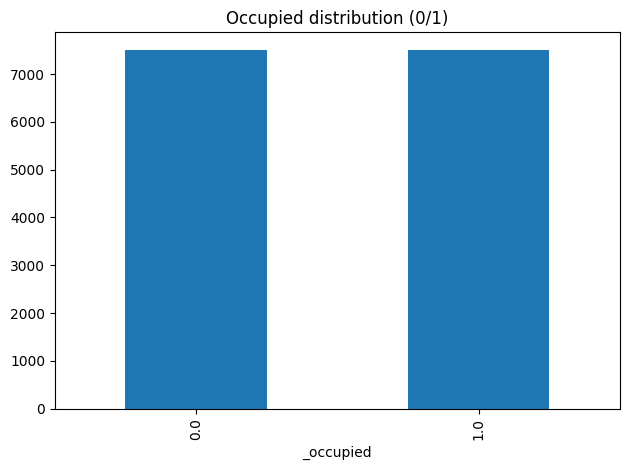

,duration_min
count,14999.000000
mean,51.556319
std,103.950892
min,0.000000
50%,9.183333
90%,146.833333
95%,306.050000
99%,450.000000
max,881.733333


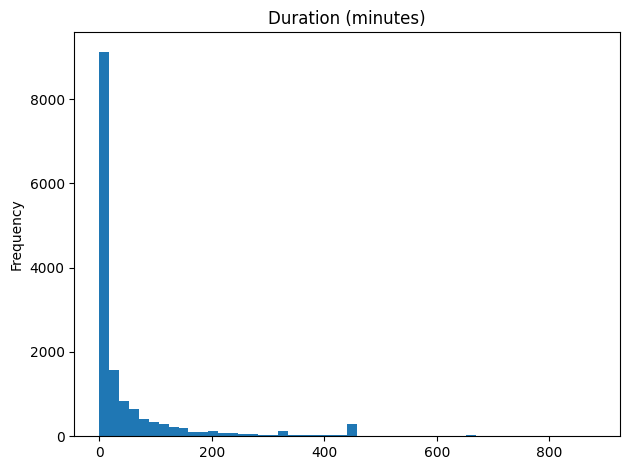

In [ ]:
# Class balance
cb = df_clean["_occupied"].value_counts().rename_axis("occupied").reset_index(name="count")
display(cb)

plt.figure()
df_clean["_occupied"].value_counts().sort_index().plot(kind="bar", title="Occupied distribution (0/1)")
plt.tight_layout(); plt.savefig(Path(OUT_DIR)/"eda_occupied_dist.png"); plt.show()

# Duration stats
dur_stats = df_clean["_duration_min"].describe(percentiles=[0.5,0.9,0.95,0.99])
display(dur_stats.to_frame("duration_min"))
plt.figure()
df_clean["_duration_min"].clip(upper=24*60).plot(kind="hist", bins=50, title="Duration (minutes)")
plt.tight_layout(); plt.savefig(Path(OUT_DIR)/"eda_duration_hist.png"); plt.show()


,hour,events,occ_rate
0,0.0,878,0.338269
1,1.0,230,0.504348
2,2.0,135,0.407407
3,3.0,115,0.400000
4,4.0,104,0.471154
5,5.0,156,0.551282
6,6.0,316,0.569620
7,7.0,984,0.415650
8,8.0,643,0.570762
9,9.0,853,0.587339


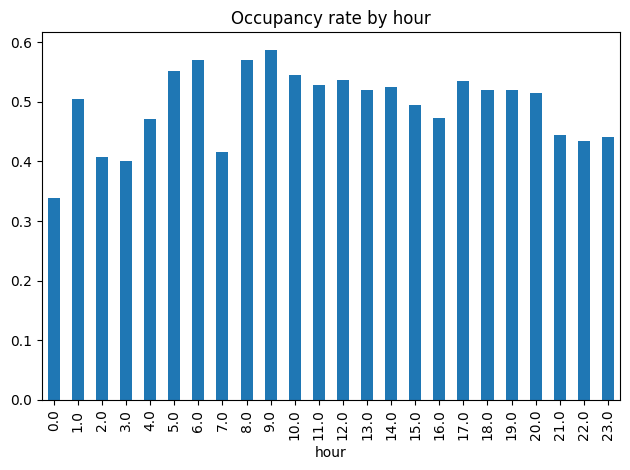

,dow,events,occ_rate
0,0.0,2103,0.495483
1,1.0,2338,0.497006
2,2.0,2369,0.499367
3,3.0,2446,0.507768
4,4.0,2485,0.513481
5,5.0,1908,0.483753
6,6.0,1350,0.497037


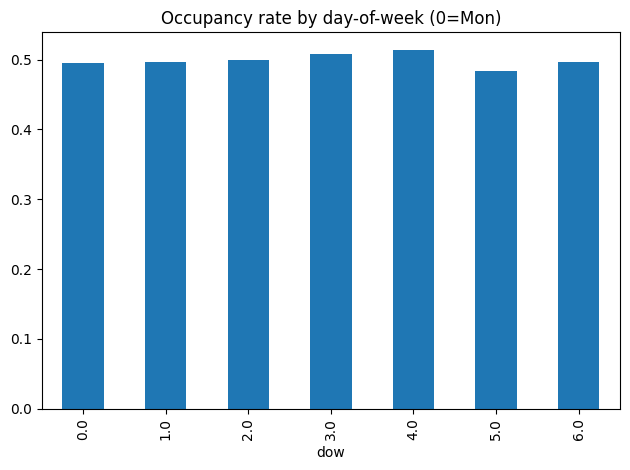

In [ ]:
by_hour = (df_clean.groupby("_hour")["_occupied"]
           .agg(events="count", occ_rate="mean")
           .reset_index().rename(columns={"_hour":"hour"}))
display(by_hour)

plt.figure()
by_hour.set_index("hour")["occ_rate"].plot(kind="bar", title="Occupancy rate by hour")
plt.tight_layout(); plt.savefig(Path(OUT_DIR)/"eda_occ_rate_by_hour.png"); plt.show()

by_dow = (df_clean.groupby("_dow")["_occupied"]
          .agg(events="count", occ_rate="mean")
          .reset_index().rename(columns={"_dow":"dow"}))
display(by_dow)

plt.figure()
by_dow.set_index("dow")["occ_rate"].plot(kind="bar", title="Occupancy rate by day-of-week (0=Mon)")
plt.tight_layout(); plt.savefig(Path(OUT_DIR)/"eda_occ_rate_by_dow.png"); plt.show()


In [ ]:
if COLS["street"]:
    by_street = (df_clean.groupby(df_clean[COLS["street"]].astype(str))["_occupied"]
                 .agg(events="size", occ_rate="mean")
                 .reset_index().rename(columns={COLS["street"]:"street_marker"})
                 .sort_values(["occ_rate","events"], ascending=[False,False]))
    display(by_street.head(25))

    # small pivot for heatmap-ready table (top 10 busy streets × hour)
    top10 = by_street.sort_values("events", ascending=False).head(10)["street_marker"].tolist()
    heat = (df_clean[df_clean[COLS["street"]].astype(str).isin(top10)]
            .pivot_table(index=df_clean[COLS["street"]].astype(str),
                         columns="_hour",
                         values="_occupied", aggfunc="mean"))
    display(heat)
else:
    print("Street/zone column not found; skipping this EDA block.")


,street_marker,events,occ_rate
1,11870E,1,1.000000
5,13228N,1,1.000000
15,3456NA,1,1.000000
18,3836N,1,1.000000
20,429W,1,1.000000
32,C5854,1,1.000000
19,3944N,1144,0.703671
14,3413S,244,0.573770
4,13085S,834,0.551559
29,8661W,80,0.537500


_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
StreetMarker,,,,,,,,,,,,,,,,,,,,,
10182E,0.160000,0.000000,NaN,NaN,0.500000,0.500000,0.583333,0.268293,0.567568,0.523077,...,0.540230,0.488889,0.517647,0.528090,0.611111,0.566667,0.458333,0.440000,0.409091,0.100000
12506N,0.450000,1.000000,0.666667,0.333333,0.000000,0.727273,0.571429,0.583333,0.608696,0.454545,...,0.650000,0.583333,0.500000,0.608696,0.468085,0.500000,0.357143,0.692308,0.333333,0.400000
13085S,0.541667,0.500000,NaN,NaN,1.000000,0.375000,0.529412,0.617021,0.600000,0.530612,...,0.500000,0.551020,0.549020,0.525424,0.589041,0.545455,0.515152,0.500000,0.586207,0.625000
1355W,0.538462,0.437500,0.200000,0.300000,0.500000,0.500000,0.483871,0.415385,0.491803,0.538462,...,0.516129,0.602410,0.355263,0.482759,0.582278,0.476190,0.571429,0.500000,0.411765,0.478261
2334N,0.458333,0.565217,0.428571,0.375000,0.571429,0.500000,0.533333,0.441860,0.448276,0.580645,...,0.487179,0.361111,0.346154,0.581395,0.608696,0.492537,0.392157,0.486486,0.433735,0.527273
3166N,0.463415,0.470588,0.500000,0.312500,0.333333,0.500000,0.368421,0.563218,0.546875,0.524390,...,0.609375,0.580000,0.486239,0.525862,0.518293,0.487500,0.580645,0.400000,0.484848,0.368421
3498N,0.482759,0.250000,0.500000,0.200000,1.000000,0.857143,0.909091,0.500000,0.473684,0.555556,...,0.321429,0.379310,0.222222,0.647059,0.583333,0.500000,0.511111,0.312500,0.473684,0.285714
3944N,0.666667,0.750000,0.500000,0.500000,1.000000,0.857143,0.545455,0.666667,0.723810,0.673267,...,0.777778,0.786667,0.714286,0.666667,0.733333,0.706897,0.718750,0.730769,0.652174,0.769231
53W,0.479452,0.534247,0.407407,0.315789,0.650000,0.437500,0.400000,0.500000,0.454545,0.590909,...,0.500000,0.571429,0.266667,0.705882,0.419355,0.333333,0.552632,0.500000,0.424242,0.447761


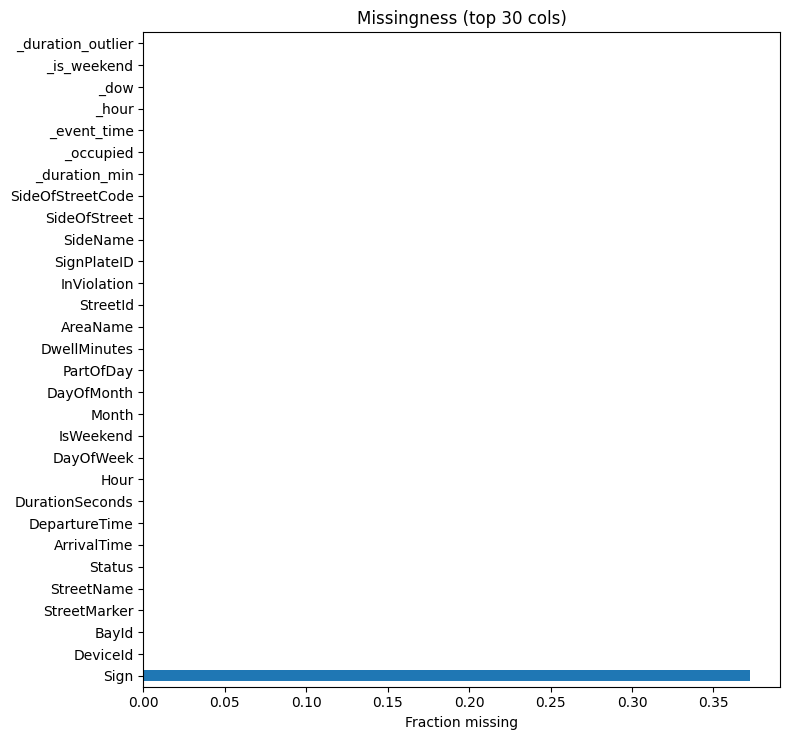

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

miss = df_clean.isna().mean().sort_values(ascending=False).head(30)
plt.figure(figsize=(8, max(3, 0.25*len(miss))))
miss.plot(kind="barh", title="Missingness (top 30 cols)")
plt.xlabel("Fraction missing"); plt.tight_layout()


,events,occ_rate
_event_time,,
2019-12-28 00:00:00+00:00,22,0.545455
2019-12-29 00:00:00+00:00,22,0.454545
2019-12-30 00:00:00+00:00,27,0.333333
2019-12-31 00:00:00+00:00,31,0.419355
2020-01-01 00:00:00+00:00,2,0.500000


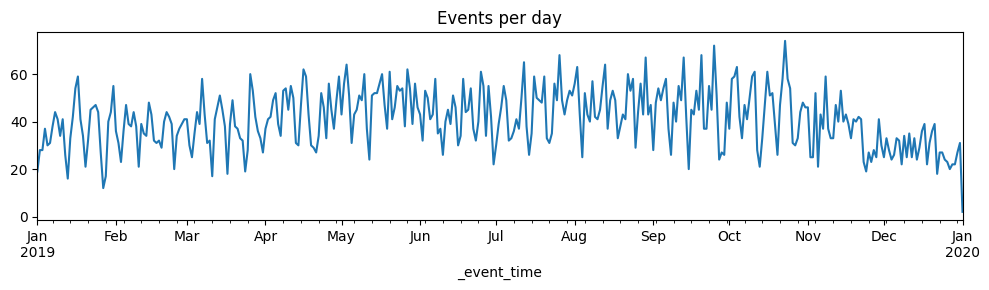

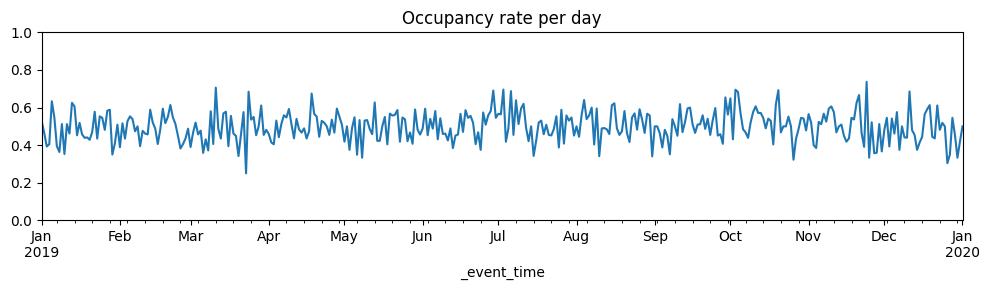

In [ ]:
# Robust daily trends (handles empty/no-datetime cases)
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure we have a proper datetime column
if "_event_time" not in df_clean.columns:
    # try to build it from typical columns
    for cand in ["ArrivalTime","arrival_time","Timestamp","timestamp"]:
        if cand in df_clean.columns:
            df_clean["_event_time"] = pd.to_datetime(df_clean[cand], errors="coerce")
            break

# 2) Guard: if no valid datetimes, skip
if "_event_time" not in df_clean.columns or df_clean["_event_time"].dropna().empty:
    print("No valid _event_time timestamps found; skipping daily trends.")
else:
    # 3) Set index and compute daily events & occupancy rate
    tmp = df_clean.loc[df_clean["_event_time"].notna(),
                       ["_event_time","_occupied"]].copy()
    tmp = tmp.set_index("_event_time").sort_index()

    # resample to daily; .size gives event counts; mean of occupied gives occ_rate
    daily_events = tmp["_occupied"].resample("D").size()
    daily_occ    = tmp["_occupied"].resample("D").mean()

    # 4) If result is empty (all NaT after resample), skip safely
    if daily_events.empty or daily_occ.empty:
        print("Daily resample produced no rows (check timestamp range). Skipping plots.")
    else:
        display(pd.DataFrame({"events": daily_events, "occ_rate": daily_occ}).tail())

        plt.figure(figsize=(10,3))
        daily_events.plot(title="Events per day")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10,3))
        daily_occ.plot(title="Occupancy rate per day")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()


In [ ]:
if COLS["street"]:
    street_stats = (df_clean
        .groupby(df_clean[COLS["street"]].astype(str))["_occupied"]
        .agg(occ_rate="mean", events="size", std="std"))
    street_stats["cv"] = street_stats["std"] / (street_stats["occ_rate"].replace(0, np.nan))
    display(street_stats.sort_values("cv", ascending=False).head(15).round(3))
else:
    print("Street column not found.")


,occ_rate,events,std,cv
StreetMarker,,,,
138E,0.330,345,0.471,1.426
C7166,0.348,155,0.478,1.372
7724N,0.349,218,0.478,1.370
5832E,0.350,123,0.479,1.370
5534E,0.361,194,0.481,1.334
C7194,0.390,182,0.489,1.254
C3084,0.402,239,0.491,1.223
5818E,0.420,157,0.495,1.178
12418N,0.422,301,0.495,1.172


In [ ]:
if COLS["street"]:
    zlist = []
    for s, g in df_clean.groupby(df_clean[COLS["street"]].astype(str)):
        if len(g) < 20:
            continue
        mu, sigma = g["_duration_min"].mean(), g["_duration_min"].std(ddof=0)
        if sigma == 0 or np.isnan(sigma):
            continue
        z = (g["_duration_min"] - mu) / sigma
        bad = g.loc[z.abs() > 3, [COLS["street"], "_duration_min", "_event_time"]].copy()
        bad["z"] = z[z.abs() > 3]
        zlist.append(bad)
    anomalies = pd.concat(zlist, ignore_index=True) if zlist else pd.DataFrame()
    display(anomalies.sort_values("z", ascending=False).head(25))
else:
    print("Street column not found.")


,StreetMarker,_duration_min,_event_time,z
52,13085S,312.700000,2019-03-26 04:39:40+00:00,15.576027
53,13085S,301.033333,2019-04-23 04:42:42+00:00,14.978973
49,13085S,251.816667,2019-01-07 06:34:44+00:00,12.460260
219,53W,222.550000,2019-01-04 16:28:30+00:00,11.294456
241,C2918,521.100000,2019-02-10 14:48:54+00:00,9.269951
156,3166N,409.033333,2019-06-26 04:00:00+00:00,8.958293
163,3166N,390.700000,2019-08-25 04:16:58+00:00,8.538607
221,53W,169.100000,2019-01-23 07:23:23+00:00,8.469639
55,1355W,754.983333,2019-01-27 05:00:00+00:00,8.453057
137,3166N,384.933333,2019-02-10 14:17:01+00:00,8.406596


In [ ]:
%%bash
set -e
apt-get -y install openjdk-11-jdk-headless >/dev/null
pip -q install pyspark==3.5.1 delta-spark==3.2.0 pyarrow findspark


In [ ]:
import findspark
findspark.init()

from delta import configure_spark_with_delta_pip
from pyspark.sql import SparkSession

builder = (
    SparkSession.builder
    .appName("parking-colab")
    .config("spark.sql.shuffle.partitions","200")
    .config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()
print("Spark:", spark.version)


Spark: 3.5.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

RAW_CSV_PATH = "/content/drive/MyDrive/smart_parking_out/smart_parking_15k.csv"   # <-- change this
BRONZE_OUT   = "/content/drive/MyDrive/parking/delta/bronze_events"     # Delta output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import functions as F

# 1) Read everything as strings (robust), then parse timestamps
raw_loose = (
    spark.read
    .option("header", True)
    .option("multiLine", True)
    .option("quote", '"')
    .option("escape", '"')
    .csv(RAW_CSV_PATH)
)

def to_ts(col):
    return F.coalesce(
        F.to_timestamp(col),
        F.to_timestamp(col, "yyyy-MM-dd HH:mm:ss"),
        F.to_timestamp(col, "MM/dd/yyyy HH:mm:ss"),
        F.to_timestamp(col, "dd/MM/yyyy HH:mm:ss")
    )

df = (raw_loose
      .withColumn("DeviceId",        F.col("DeviceId"))
      .withColumn("StreetMarker",    F.col("StreetMarker"))
      .withColumn("SignPlateID",     F.col("SignPlateID"))
      .withColumn("Status",          F.col("Status"))
      .withColumn("ArrivalTime",     to_ts(F.col("ArrivalTime")))
      .withColumn("DepartureTime",   to_ts(F.col("DepartureTime")))
)

# 2) Build duration expression ONLY from columns that actually exist
cols = set(df.columns)
duration_exprs = []
if "DurationMinutes" in cols:
    duration_exprs.append(F.col("DurationMinutes").cast("double"))
if "DwellMinutes" in cols:
    duration_exprs.append(F.col("DwellMinutes").cast("double"))
if "DurationSeconds" in cols:
    duration_exprs.append(F.col("DurationSeconds").cast("double") / 60.0)

from functools import reduce
if duration_exprs:
    dm_expr = reduce(lambda a, b: F.coalesce(a, b), duration_exprs)  # coalesce over available cols
    df = df.withColumn("DurationMinutes_raw", dm_expr)
else:
    df = df.withColumn("DurationMinutes_raw", F.lit(None).cast("double"))

print("Columns detected:", sorted(df.columns))
df.select(
    "DeviceId","StreetMarker","ArrivalTime","DepartureTime","Status",
    *[c for c in ["DurationMinutes","DwellMinutes","DurationSeconds","DurationMinutes_raw"] if c in df.columns]
).show(10, truncate=False)


Columns detected: ['AreaName', 'ArrivalTime', 'BayId', 'DayOfMonth', 'DayOfWeek', 'DepartureTime', 'DeviceId', 'DurationMinutes_raw', 'DurationSeconds', 'DwellMinutes', 'Hour', 'InViolation', 'IsWeekend', 'Month', 'PartOfDay', 'SideName', 'SideOfStreet', 'SideOfStreetCode', 'Sign', 'SignPlateID', 'Status', 'StreetId', 'StreetMarker', 'StreetName']
+--------+------------+-------------------+-------------------+----------+------------+---------------+-------------------+
|DeviceId|StreetMarker|ArrivalTime        |DepartureTime      |Status    |DwellMinutes|DurationSeconds|DurationMinutes_raw|
+--------+------------+-------------------+-------------------+----------+------------+---------------+-------------------+
|23933   |C9190       |2019-03-16 00:00:00|2019-03-16 07:30:00|NotPresent|450.0       |27000.0        |450.0              |
|23967   |13085S      |2019-01-10 18:30:00|2019-01-10 18:30:59|Present   |0.0         |0.0            |0.0                |
|23913   |1581S       |2019-11

In [ ]:
from pyspark.sql import functions as F

# If the table already exists, skip creation.
if not spark._jsparkSession.catalog().tableExists("parking_bronze"):
    # Read CSV as strings, then parse
    raw = (spark.read.option("header", True)
           .option("multiLine", True).option("quote", '"').option("escape", '"')
           .csv(RAW_CSV_PATH))

    def to_ts(c):
        return F.coalesce(
            F.to_timestamp(c),
            F.to_timestamp(c, "yyyy-MM-dd HH:mm:ss"),
            F.to_timestamp(c, "MM/dd/yyyy HH:mm:ss"),
            F.to_timestamp(c, "dd/MM/yyyy HH:mm:ss")
        )

    df = (raw
          .withColumn("DeviceId",      F.col("DeviceId"))
          .withColumn("StreetMarker",  F.col("StreetMarker"))
          .withColumn("SignPlateID",   F.col("SignPlateID"))
          .withColumn("Status",        F.col("Status"))
          .withColumn("ArrivalTime",   to_ts(F.col("ArrivalTime")))
          .withColumn("DepartureTime", to_ts(F.col("DepartureTime"))))

    # Build duration from whatever exists (DurationMinutes / DwellMinutes / DurationSeconds / timestamps)
    cols = set(df.columns)
    dur_exprs = []
    if "DurationMinutes" in cols: dur_exprs.append(F.col("DurationMinutes").cast("double"))
    if "DwellMinutes"    in cols: dur_exprs.append(F.col("DwellMinutes").cast("double"))
    if "DurationSeconds" in cols: dur_exprs.append(F.col("DurationSeconds").cast("double")/60.0)

    from functools import reduce
    dm_raw = reduce(lambda a,b: F.coalesce(a,b), dur_exprs) if dur_exprs else F.lit(None).cast("double")

    bronze = (df
      .withColumn("status_norm", F.lower(F.trim(F.col("Status"))))
      .withColumn("arrive_ts", F.col("ArrivalTime"))
      .withColumn("depart_ts", F.col("DepartureTime"))
      .withColumn("event_time", F.coalesce(F.col("ArrivalTime"), F.col("DepartureTime")))
      .withColumn("duration_min", F.coalesce(dm_raw, (F.col("DepartureTime").cast("long")-F.col("ArrivalTime").cast("long"))/60.0))
      .filter("event_time IS NOT NULL AND duration_min >= 0 AND duration_min <= 1440")
      .withColumn("event_date", F.to_date("event_time"))
      .withColumnRenamed("DeviceId","device_id")
      .withColumnRenamed("StreetMarker","street_marker")
      .withColumnRenamed("SignPlateID","sign_plate_id")
    )

    (bronze.write.format("delta").mode("overwrite").partitionBy("event_date").save(BRONZE_OUT))
    spark.sql("DROP TABLE IF EXISTS parking_bronze")
    spark.sql(f"CREATE TABLE parking_bronze USING DELTA LOCATION '{BRONZE_OUT}'")

spark.sql("SELECT COUNT(*) AS rows FROM parking_bronze").show()


+-----+
| rows|
+-----+
|15000|
+-----+



In [ ]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW silver_base AS
SELECT
  device_id,
  street_marker,
  event_time,
  LOWER(TRIM(status_norm)) AS status_norm,
  CASE WHEN LOWER(TRIM(status_norm)) IN ('present','occupied','1','true') THEN 1 ELSE 0 END AS occupied,
  duration_min,
  HOUR(event_time)      AS hour,
  dayofweek(event_time) AS dow,         -- 1=Sun..7=Sat
  CASE WHEN dayofweek(event_time) IN (1,7) THEN 1 ELSE 0 END AS is_weekend
FROM parking_bronze
WHERE event_time IS NOT NULL AND duration_min BETWEEN 0 AND 1440
""")
spark.sql("SELECT * FROM silver_base LIMIT 5").show(truncate=False)


+---------+-------------+-------------------+-----------+--------+------------+----+---+----------+
|device_id|street_marker|event_time         |status_norm|occupied|duration_min|hour|dow|is_weekend|
+---------+-------------+-------------------+-----------+--------+------------+----+---+----------+
|23944    |3166N        |2019-10-23 09:32:27|present    |1       |6.0         |9   |4  |0         |
|23944    |3166N        |2019-10-23 11:24:53|present    |1       |1.0         |11  |4  |0         |
|23913    |1581S        |2019-10-23 00:14:27|notpresent |0       |7.0         |0   |4  |0         |
|23928    |10182E       |2019-10-23 18:29:02|present    |1       |0.0         |18  |4  |0         |
|23917    |C2918        |2019-10-23 12:41:10|present    |1       |68.0        |12  |4  |0         |
+---------+-------------+-------------------+-----------+--------+------------+----+---+----------+



In [ ]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW silver_history AS
SELECT
  *,
  LAG(occupied, 1) OVER (PARTITION BY device_id ORDER BY event_time) AS occ_lag1,
  LAG(occupied, 2) OVER (PARTITION BY device_id ORDER BY event_time) AS occ_lag2,
  AVG(occupied)     OVER (PARTITION BY device_id ORDER BY event_time ROWS BETWEEN 9 PRECEDING AND 1 PRECEDING) AS occ_roll10_past,
  AVG(duration_min) OVER (PARTITION BY device_id ORDER BY event_time ROWS BETWEEN 9 PRECEDING AND 1 PRECEDING) AS dur_roll10_past
FROM silver_base
""")
spark.sql("SELECT device_id, event_time, occ_lag1, occ_lag2, occ_roll10_past, dur_roll10_past FROM silver_history LIMIT 5").show(truncate=False)


+---------+-------------------+--------+--------+---------------+------------------+
|device_id|event_time         |occ_lag1|occ_lag2|occ_roll10_past|dur_roll10_past   |
+---------+-------------------+--------+--------+---------------+------------------+
|23913    |2019-09-01 04:06:25|NULL    |NULL    |NULL           |NULL              |
|23913    |2019-09-01 16:13:22|1       |NULL    |1.0            |1.0               |
|23913    |2019-09-01 18:27:22|1       |1       |1.0            |0.5               |
|23913    |2019-09-03 09:30:00|1       |1       |1.0            |0.3333333333333333|
|23913    |2019-09-03 10:53:24|0       |1       |0.75           |20.0              |
+---------+-------------------+--------+--------+---------------+------------------+



In [ ]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW silver_priors AS
WITH pri AS (
  SELECT street_marker, hour, dow, AVG(occupied) AS street_hour_dow_occ_prior, COUNT(*) AS n
  FROM silver_base
  GROUP BY street_marker, hour, dow
)
SELECT h.*, p.street_hour_dow_occ_prior
FROM silver_history h
LEFT JOIN pri p
  ON h.street_marker = p.street_marker AND h.hour = p.hour AND h.dow = p.dow
""")
spark.sql("SELECT street_marker, hour, dow, street_hour_dow_occ_prior FROM silver_priors LIMIT 5").show(truncate=False)


+-------------+----+---+-------------------------+
|street_marker|hour|dow|street_hour_dow_occ_prior|
+-------------+----+---+-------------------------+
|3166N        |9   |4  |0.6470588235294118       |
|3166N        |11  |4  |0.4375                   |
|1581S        |0   |4  |0.6666666666666666       |
|10182E       |18  |4  |0.4444444444444444       |
|C2918        |12  |4  |0.4                      |
+-------------+----+---+-------------------------+



In [ ]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW label_next15 AS
SELECT
  a.device_id,
  a.event_time,
  MAX(b.occupied) AS occ_in_next_15m
FROM silver_base a
LEFT JOIN silver_base b
  ON a.device_id = b.device_id
 AND b.event_time >  a.event_time
 AND b.event_time <= a.event_time + INTERVAL 15 MINUTES
GROUP BY a.device_id, a.event_time
""")
spark.sql("SELECT * FROM label_next15 LIMIT 5").show(truncate=False)


+---------+-------------------+---------------+
|device_id|event_time         |occ_in_next_15m|
+---------+-------------------+---------------+
|23944    |2019-09-25 07:38:39|NULL           |
|23917    |2019-08-29 18:30:00|NULL           |
|23941    |2019-10-04 07:00:34|1              |
|23941    |2019-10-02 06:47:48|NULL           |
|23970    |2019-07-26 00:31:43|0              |
+---------+-------------------+---------------+



In [ ]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW train_ready AS
SELECT
  sp.device_id,
  sp.street_marker,
  sp.event_time,
  sp.hour, sp.dow, sp.is_weekend,
  sp.duration_min,
  sp.occ_lag1, sp.occ_lag2, sp.occ_roll10_past, sp.dur_roll10_past,
  COALESCE(sp.street_hour_dow_occ_prior, 0.5) AS street_hour_dow_occ_prior,
  lbl.occ_in_next_15m                         AS label,
  PERCENT_RANK() OVER (ORDER BY sp.event_time) AS pr
FROM silver_priors sp
JOIN label_next15  lbl
  ON sp.device_id = lbl.device_id AND sp.event_time = lbl.event_time
WHERE lbl.occ_in_next_15m IS NOT NULL
""")
spark.sql("SELECT COUNT(*) AS rows, MIN(event_time) AS min_t, MAX(event_time) AS max_t FROM train_ready").show(truncate=False)


+----+-------------------+-------------------+
|rows|min_t              |max_t              |
+----+-------------------+-------------------+
|1046|2019-01-01 01:18:24|2019-12-31 07:46:04|
+----+-------------------+-------------------+

